In [1]:
import pandas as pd
import numpy as np
# matplotlib is the Python library for drawing diagrams
import matplotlib.pylab as plt
%matplotlib inline
# set the size of the diagrams
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,5
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import warnings
from statsmodels.tsa.arima_model import ARIMA
import timeit
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from fbprophet import Prophet

## Dataprep

In [2]:
ts = pd.read_csv('./data/dataframe_yearly.csv', index_col=0, usecols=[0,2])

In [3]:
ts.head()

,ice_extent
Year,
1979,12.349634
1980,12.349545
1981,12.147230
1982,12.467336
1983,12.353095


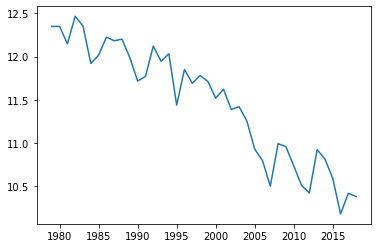

In [4]:
plt.plot(ts)

### Differentiatie

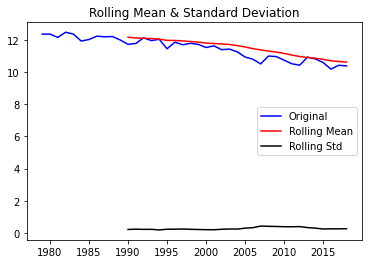

In [5]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(ts)

Duidelijk dalende trend dus passen we differentiatie toe

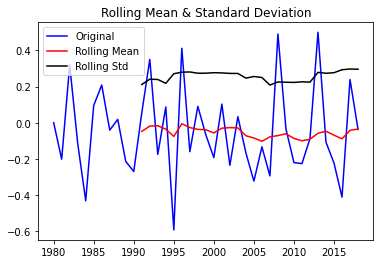

In [6]:
ts_diff = ts - ts.shift(1)
ts_diff = ts_diff.dropna()
test_stationarity(ts_diff)

Deze data is stationair dus kunnen we modellen beginnen opbouwen

### Cross validation setup

In [7]:
tscv = TimeSeriesSplit(n_splits = 8)

for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        print("TRAIN:", train_index.size) # visiualize cross_validation structure for reference
        print("TEST:", test_index.size)
        print()

TRAIN: 23
TEST: 4

TRAIN: 27
TEST: 4

TRAIN: 31
TEST: 4

TRAIN: 35
TEST: 4



### General methods

In [8]:
def full_graph(predicted_diff, title):
    predictionsArray = np.asarray(revert_diff(predicted_diff, ts))
    zerosArray = np.zeros(ts.values.size-len(predictionsArray.flatten()))
    cleanPrediction = pd.Series(np.concatenate((zerosArray,predictionsArray))).replace(0,np.NaN)
    
    # plot
    plt.title(title)
    plt.plot(ts.values,marker='o', color='blue',label='Actual values')
    plt.plot(cleanPrediction,marker='o', color='red',label='Last 3 year prediction')
    plt.ylim([0,15])
    plt.legend()

    plt.show()
    
def revert_diff(predicted_diff, og_data):
    last_value = og_data.iloc[-predicted_diff.size-1][0]
    predicted_actual = np.array([])
    for value_diff in predicted_diff:
        actual_value = last_value + value_diff
        predicted_actual = np.append(predicted_actual, actual_value)
        last_value = actual_value
    return predicted_actual

### ARIMA

In [9]:
%%time
# ARIMA
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
import sys
from sklearn.metrics import mean_absolute_error



# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 5)
d = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
best_pdq = pdq
best_mean_mae = np.inf
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    print(param)
    try:   # some parametercombinations might lead to crash, so catch exceptions and continue
        maes = []
        for train_index, test_index in tscv.split(ts_diff):
            if train_index.size > 20:
                # initialize cross validation train and test sets
                cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

                # build model
                model = ARIMA(cv_train, order=(param))
                model_fit = model.fit()

                # make predictions
                predictions =  model_fit.predict(start=len(cv_train), end=len(cv_train)+cv_test.size-1, dynamic=False)
                prediction_values = predictions.values
                true_values = cv_test.values
                # error calc
                #     print(true_values)
                #     print(predictions.values)
                maes.append(mean_absolute_error(true_values, prediction_values))

        
        mean_mae = np.mean(maes)
        print('MAE: ' + str(mean_mae))    

        if mean_mae < best_mean_mae:
            best_mean_mae = mean_mae
            best_maes = maes
            best_pdq = param
            best_predictions = prediction_values
    except Exception as e:
        print(e)
        continue
   
# plot
print()
print('Best MAE = ' + str(best_mean_mae))
print(best_pdq)

# best range(0,10): 

(0, 0, 0)
MAE: 0.20032300657400814
(0, 0, 1)
MAE: 0.2074012843296259
(0, 0, 2)
MAE: 0.20990433179675155
(0, 0, 3)
Input contains NaN, infinity or a value too large for dtype('float64').
(0, 0, 4)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1310, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 30, in <module>
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py", line 1030, in fit
    callback=callback, **kwargs)
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\base\model.py", line 527, in fit
    full_output=full_output)
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py", line 227, in _fit
    hess=hessian)
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py", line 632, in _fit_lbfgs
    **extra_kwargs)
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py", line 199, in fmin_l_bfgs_b
    **opts)
  File "C:\Users\Emiel\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py", line 345, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "C:\Users\Emiel\Ana

KeyboardInterrupt: 

In [22]:
best_pdq = (3, 0, 0)

----
IIII
Mean MAE: 0.171 x 1 000 000 km²
MAE of last prediction: 0.103 x 1 000 000 km²
Execution time: 0.370 seconds


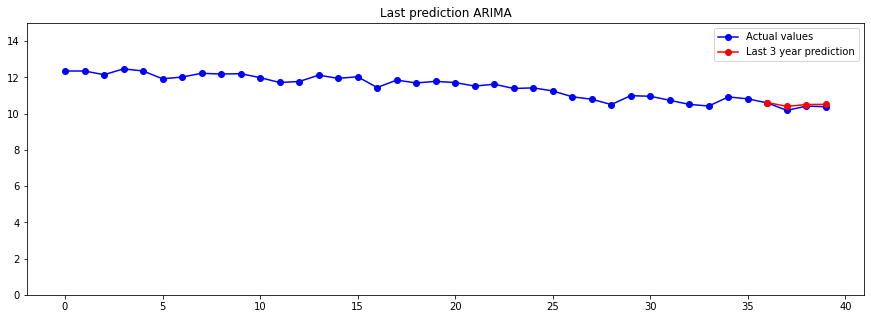

In [23]:
start_time = timeit.default_timer()


warnings.filterwarnings("ignore") # specify to ignore warning messages

print("----")

maes = []

for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:

        # initialize cross validation train and test sets
        cv_train, cv_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        # build model
        arima = ARIMA(cv_train, best_pdq).fit(start_ar_lags=1,disp=False)

        # make predictions
        predictions = arima.forecast(steps=4)
        prediction_values = predictions[0]
        true_values = cv_test.values

        # error calc
        maes.append(mean_absolute_error(true_values, prediction_values))

        # last actual prediction 
        last_prediction_ARIMA = prediction_values

        print("I",end="")

time_ARIMA = timeit.default_timer() - start_time
mae_mean = np.mean(maes)
MAE_ARIMA = mae_mean
last_MAE_ARIMA = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_ARIMA)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_ARIMA)
print('Execution time: %.3f seconds' % time_ARIMA)
full_graph(last_prediction_ARIMA, 'Last prediction ARIMA')

# LSTM

https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

## Functions 

In [49]:
from keras.layers import Dropout


# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
def build_model(raw_seq, n_steps_in, n_steps_out, n_features, n_neurons, dropout, batch_s):
    
    # split into samples
    X, y = split_sequence(raw_seq.values.flatten(), n_steps_in, n_steps_out)
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    # define model
    model = Sequential()
    model.add(LSTM(n_neurons, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mae')
    
    # fit model
    model.fit(X, y, batch_size=batch_s, epochs=100, verbose=0)
    
    return model


def predict(x_input, model, n_features):
    n_features = 1
    x_input = x_input.reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

## Determine hyperparameters 

----
IIII
1
0
1
0.2034605440123094

----
IIII
1
0
2
0.2035879344504472

----
IIII
1
0
4
0.20324603692930832

----
IIII
1
0
8
0.20328966727782305

----
IIII
1
0.5
1
0.2030421034767437

----
IIII
1
0.5
2
0.20251521132908423

----
IIII
1
0.5
4
0.20260963821877434

----
IIII
1
0.5
8
0.20225486519466152

----
IIII
1
0.99
1
0.20202705617759087

----
IIII
1
0.99
2
0.20230417212703392

----
IIII
1
0.99
4
0.20221279859799796

----
IIII
1
0.99
8
0.2020375142191552

----
IIII
5
0
1
0.20253322357866838

----
IIII
5
0
2
0.20268608026963797

----
IIII
5
0
4
0.20268876497553603

----
IIII
5
0
8
0.20273873959964725

----
IIII
5
0.5
1
0.20204414811272134

----
IIII
5
0.5
2
0.20183616953352074

----
IIII
5
0.5
4
0.20160961792694485

----
IIII
5
0.5
8
0.20141848580115324

----
IIII
5
0.99
1
0.20141373863741815

----
IIII
5
0.99
2
0.20125122647543953

----
IIII
5
0.99
4
0.20119514193869045

----
IIII
5
0.99
8
0.20111841616444215

----
IIII
10
0
1
0.20224559911548387

----
IIII
10
0
2
0.2027829657609303

-

<BarContainer object of 48 artists>

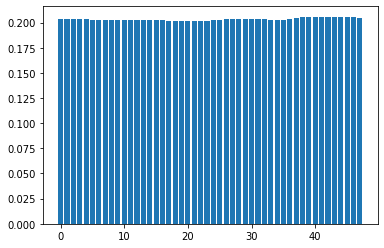

In [60]:
%%time

start_time = timeit.default_timer()

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# constant variables
n_steps_in = 4
n_steps_out = 4
n_features  = 1
maes = []
global_maes = []

# optimizable variables
n_neurons_array = [1,5,10,20]
dropout_array = [0,0.5,0.99]
batch_size_array = [1,2,4,8]


# initialize values
best_MAE = 100
best_n_neurons = 0
best_activation = 'none'
best_dropout = 0
best_batch_size = 0

for n_neurons in n_neurons_array:
    for dropout in dropout_array:
        for batch_size in batch_size_array:

            print("----")
            for train_index, test_index in tscv.split(ts_diff): 
                if train_index.size > 20:  
                    # initialize cross validation train and test sets
                    y_train, y_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

                    # build model
                    lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features, n_neurons, dropout, batch_size)

                    # make predictions
                    x_input = array(y_test)
                    y_predicted = predict(x_input, lstm_model, n_features).flatten()
                    y_actual = y_test.values

                    # error calc
                    maes.append(mean_absolute_error(y_actual, y_predicted))

                    print("I",end="")

                # last actual prediction 
                last_prediction_LSTM = y_predicted

            time_LSTM = timeit.default_timer() - start_time
            MAE_LSTM = np.mean(maes)
            last_MAE_LSTM = maes[-1]
            global_maes.append(MAE_LSTM)

            if best_MAE > MAE_LSTM:
                best_n_neurons = n_neurons
                best_dropout = dropout
                best_batch_size = batch_size
                best_MAE = MAE_LSTM

            print()
            print(n_neurons)
            print(dropout)
            print(batch_size)
            print(MAE_LSTM)
            print()    


print('Best:')
print('N neurons')
print(best_n_neurons)
print('Dropout rate')
print(best_dropout)
print('Batch size')
print(best_batch_size)
print('MAE')
print(best_MAE)
plt.bar(range(0,len(global_maes)), global_maes)

In [ ]:
# Run #1 Best:
# 1
# 0
# 1
# 0.1919512481592649
# Wall time: 8min 36s

# Run #2 Best:
# 1
# 0.5
# 1
# 0.19969739902546374
# Wall time: 7min 16s

# Run #3 Best:
# 5
# 0.99
# 8
# 0.20111841616444215
# Wall time: 6min 47s

## Final result LSTM

In [28]:
%%time

start_time = timeit.default_timer()

# Disabled tf warning because of visual clutter
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# constant variables
n_steps_in = 4
n_steps_out = 4
n_features  = 1
maes = []


# optimizable variables
n_neurons = 3000

print("----")
for train_index, test_index in tscv.split(ts_diff):
    if train_index.size > 20:  
        # initialize cross validation train and test sets
        y_train, y_test = ts_diff.iloc[train_index], ts_diff.iloc[test_index]

        # build model
        lstm_model = build_model(y_train, n_steps_in, n_steps_out, n_features, n_neurons)

        # make predictions
        x_input = array(y_test)
        y_predicted = predict(x_input, lstm_model, n_features).flatten()
        y_actual = y_test.values

        # error calc
        maes.append(mean_absolute_error(y_actual, y_predicted))

        print("I",end="")

# last actual prediction 
last_prediction_LSTM = y_predicted
 
time_LSTM = timeit.default_timer() - start_time
MAE_LSTM = np.mean(maes)
last_MAE_LSTM = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_LSTM)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_LSTM)
print('Execution time: %.3f seconds' % time_LSTM)
full_graph(last_prediction_LSTM, 'Last prediction LSTM')

----
I

KeyboardInterrupt: 

### Prophet

----------


INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


I

INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


III
Mean MAE: 0.164 x 1 000 000 km²
MAE of last prediction: 0.149 x 1 000 000 km²
Execution time: 43.794 seconds


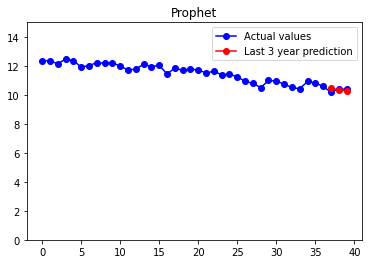

In [13]:
# Disabled tf warning because of clutter
warnings.filterwarnings("ignore") # specify to ignore warning messages

maes = []

# formatting dataframe
ts_formated_prophet = ts_moving_avg_diff.reset_index().rename(columns = {'Year' : 'ds', 'ice_extent' : 'y'})
ts_formated_prophet['ds'] = pd.DataFrame(pd.to_datetime(ts_formated_prophet['ds'].astype(str), format='%Y'))

print("----------")

for train_index, test_index in tscv.split(ts_formated_prophet):

    # initialize cross validation train and test sets
    train  = ts_formated_prophet.iloc[train_index]
    y_test = ts_formated_prophet.iloc[test_index][['y']].values.flatten()
    X_test = ts_formated_prophet.iloc[test_index][['ds']]
        
    # build model
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(train)

    # make predictions
    forecast = model.predict(X_test)
    y_pred = forecast['yhat'].values
    
    # error calc
    maes.append(mean_absolute_error(y_test, y_pred))
    
    # last actual prediction 
    last_prediction_prophet = y_pred + moving_avg.dropna().iloc[test_index].values.flatten()

    print("I",end="")

time_Prophet = timeit.default_timer() - start_time
MAE_Prophet = np.mean(maes)
last_MAE_Prophet = maes[-1]

print()
print('Mean MAE: %.3f x 1 000 000 km\u00b2' % MAE_Prophet)
print('MAE of last prediction: %.3f x 1 000 000 km\u00b2' % last_MAE_Prophet)
print('Execution time: %.3f seconds' % time_Prophet)
full_graph(last_prediction_prophet, "Prophet")

### Evaluation

In [14]:
results = [[MAE_ARIMA,time_ARIMA,last_MAE_ARIMA],[MAE_LSTM,time_LSTM,last_MAE_LSTM],[MAE_Prophet,time_Prophet,last_MAE_Prophet]]
pd.DataFrame(results, columns=['Mean MAE (x 1 000 000 km\u00b2)','Execution time (s)','Last MAE (x 1 000 000 km\u00b2)'],index=['ARIMA','LSTM','Prophet']).round(decimals=3)


,Mean MAE (x 1 000 000 km²),Execution time (s),Last MAE (x 1 000 000 km²)
ARIMA,0.119,0.802,0.066
LSTM,0.183,24.999,0.215
Prophet,0.164,43.794,0.149


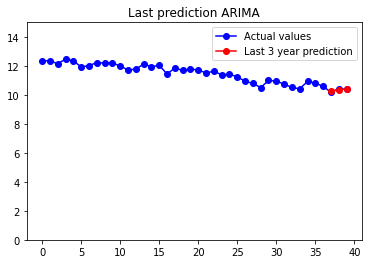

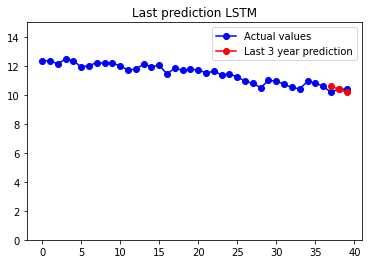

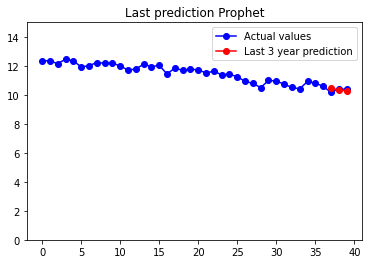

In [15]:
full_graph(last_prediction_ARIMA, "Last prediction ARIMA")
full_graph(last_prediction_LSTM, "Last prediction LSTM")
full_graph(last_prediction_prophet, "Last prediction Prophet")